<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/work_from_here/impulse_nifty50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --q

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


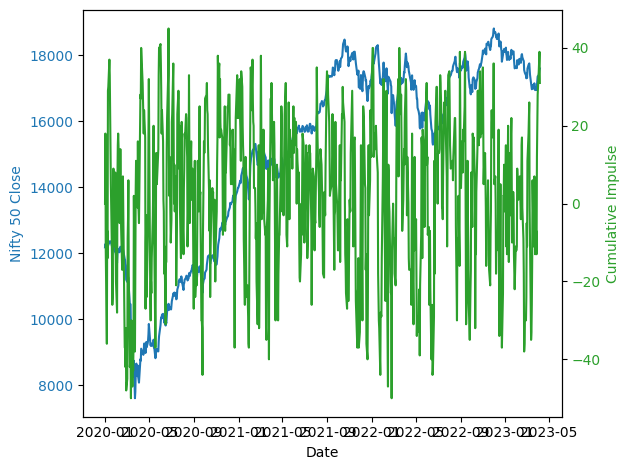

In [4]:

# Fetch Nifty 50 constituents
nifty50_url = "https://archives.nseindia.com/content/indices/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()

# Fetch historical data for the last two years
start_date = "2020-01-01"

data = yf.download(tickers, start=start_date)['Close']

# Calculate impulses for each stock
impulses = []

for ticker in data.columns:
    stock_data = data[ticker].dropna()
    ema13 = stock_data.ewm(span=13).mean()
    ema12 = stock_data.ewm(span=12).mean()
    ema26 = stock_data.ewm(span=26).mean()
    
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9).mean()
    macd_histogram = macd - macd_signal
    
    impulse = pd.Series(index=stock_data.index, dtype=int)
    
    for i in range(1, len(stock_data)):
        if macd_histogram.iloc[i] > macd_histogram.iloc[i - 1] and stock_data.iloc[i] > ema13.iloc[i]:
            impulse.iloc[i] = 1
        elif macd_histogram.iloc[i] < macd_histogram.iloc[i - 1] and stock_data.iloc[i] < ema13.iloc[i]:
            impulse.iloc[i] = -1
        else:
            impulse.iloc[i] = 0
            
    impulses.append(impulse)

# Combine impulses
combined_impulses = pd.concat(impulses, axis=1)
combined_impulses.columns = data.columns
cumulative_impulse = combined_impulses.sum(axis=1)

# Fetch Nifty 50 index data
nifty50_data = yf.download("^NSEI", start=start_date)['Adj Close']

# Plot Nifty 50 close and cumulative impulse
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Nifty 50 Close', color='tab:blue')
ax1.plot(nifty50_data.index, nifty50_data, color='tab:blue', label='Nifty 50 Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Impulse', color='tab:green')
ax2.plot(cumulative_impulse.index, cumulative_impulse, color='tab:green', label='Cumulative Impulse')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.show()


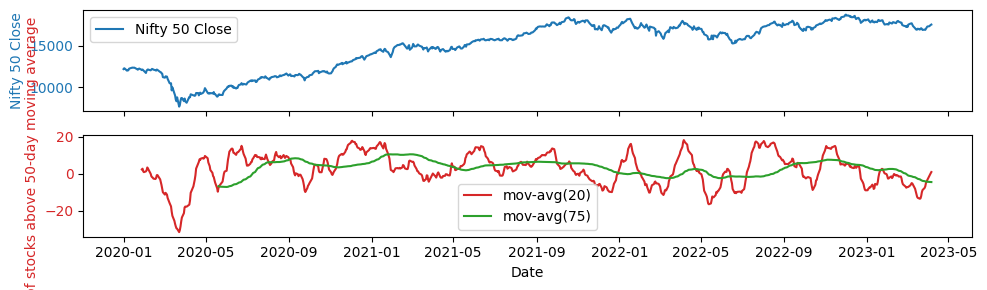

In [26]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,3), sharex=True)

# Plot Nifty 50 close on the first subplot
ax1.plot(nifty50_data.index, nifty50_data, color='tab:blue', label='Nifty 50 Close')
ax1.set_ylabel('Nifty 50 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend()

# Plot the number of stocks trading above their 50-day moving average on the second subplot
#ax2.plot(cumulative_impulse.index, cumulative_impulse, color='tab:red', label='Cumulative Impulse')
ax2.plot(cumulative_impulse.index,cumulative_impulse.rolling(window=20).mean(),color='tab:red', label='mov-avg(20)')
ax2.plot(cumulative_impulse.index,cumulative_impulse.rolling(window=20).mean().rolling(window=75).mean(),color='tab:green', label='mov-avg(75)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of stocks above 50-day moving average', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend()
fig.tight_layout()
plt.show()


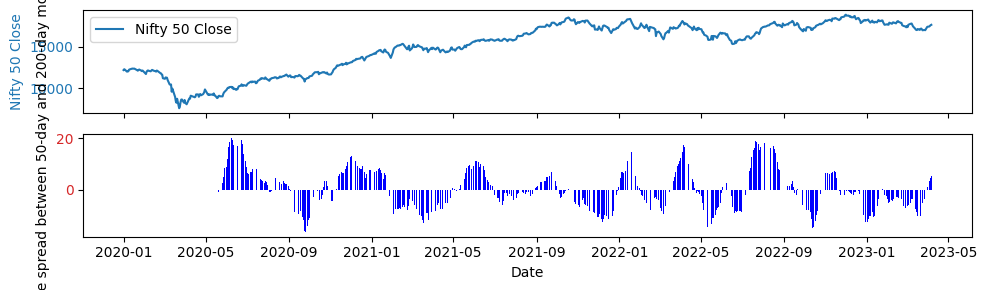

In [28]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,3), sharex=True)

# Plot Nifty 50 close on the first subplot
ax1.plot(nifty50_data.index, nifty50_data, color='tab:blue', label='Nifty 50 Close')
ax1.set_ylabel('Nifty 50 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend()



spread = cumulative_impulse.rolling(window=20).mean() - cumulative_impulse.rolling(window=20).mean().rolling(window=75).mean()

# Plot the histogram of the spread
ax2.bar(cumulative_impulse.index[-len(spread.dropna()):,],spread.dropna(), color='blue')
ax2.set_xlabel('Date')
ax2.set_ylabel('Frequency Histogram of the spread between 50-day and 200-day moving averages')
ax2.tick_params(axis='y', labelcolor='tab:red')
#ax3.legend()

fig.tight_layout()
plt.show()
